**preprocesamiento**

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [ ]:
"""def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and \
                hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer   = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer  (shape  =len(old_biases))])"""

"def reset_weights(model):\n    for ix, layer in enumerate(model.layers):\n        if hasattr(model.layers[ix], 'kernel_initializer') and                 hasattr(model.layers[ix], 'bias_initializer'):\n            weight_initializer = model.layers[ix].kernel_initializer\n            bias_initializer   = model.layers[ix].bias_initializer\n\n            old_weights, old_biases = model.layers[ix].get_weights()\n\n            model.layers[ix].set_weights([\n                weight_initializer(shape=old_weights.shape),\n                bias_initializer  (shape  =len(old_biases))])"

In [ ]:
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

In [ ]:
(buffer_size,img_rows, img_cols, channels) = X_train.shape
img_shape  = (img_rows, img_cols, channels)
z_dim      = 200     # dimensión del espacio latente
batch_size = 256
num_epochs = 150
each_save  = 75

path_results = 'dcgan_results/'

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

**Contrucción del modelo de generador**

In [ ]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.utils import plot_model

def build_generator(img_shape, z_dim, verbose=False):

    z = Input(shape=(z_dim,))

    X = Dense(256 * 7 * 7, input_dim=z_dim) (z)
    X = Reshape((7, 7, 256))(X)

    X = Conv2DTranspose(filters    =128,
                        kernel_size=3,
                        strides    =2,
                        padding    ='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)

    X = Conv2DTranspose(filters    =64,
                        kernel_size=3,
                        strides    =1,
                        padding    ='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)

    Y = Conv2DTranspose(filters    =1,
                        kernel_size=3,
                        strides    =2,
                        padding    ='same',
                        activation ='tanh')(X)

    generator_model = Model(inputs = z, outputs = [Y], name ='generator')

    return generator_model

In [ ]:
generator = build_generator(img_shape, z_dim)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_6 (Dense)             (None, 12544)             2521344   
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 14, 14, 128)       295040    
 Transpose)                                                      
                                                                 
 batch_normalization_12 (Ba  (None, 14, 14, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 128)       0 

**`Creación del discriminador`**

In [ ]:
def build_discriminator(img_shape, verbose=False):

    Xin = Input(shape=(img_shape[0],img_shape[1],img_shape[2],))

    X = Conv2D(filters     = 32,
               kernel_size = 3,
               strides     = 2,
               input_shape = img_shape,
               padding     = 'same')(Xin)

    X = LeakyReLU(alpha    = 0.01)(X)

    X = Conv2D(filters     = 64,
               kernel_size = 3,
               strides     = 2,
               padding     = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)

    X = Conv2D(filters     = 128,
               kernel_size = 3,
               strides     = 2,
               padding     = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)

    X = Flatten()(X)
    Yout = Dense(1, activation='sigmoid')(X)

    discriminator_model = Model(inputs = Xin, outputs = [Yout], name ='discriminator')

    return discriminator_model

In [ ]:
# construye el discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_14 (Ba  (None, 7, 7, 64)          256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                     

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss_classic(real_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(tf.keras.backend.log(real_output) + tf.keras.backend.log(1.- fake_output))
    return total_loss

In [ ]:
def generator_loss_classic(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(real_output,fake_output):
    total_loss = -tf.reduce_mean(tf.keras.backend.log(fake_output))
    return total_loss

In [ ]:
generator_optimizer     = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

**Creación de bucle de de entrenamiento.**

In [ ]:
@tf.function
def train_step(images):

    z = tf.random.normal([images.shape[0], z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(z, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss  = generator_loss(real_output, fake_output)

    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
from PIL import Image
import imageio
import glob

num_examples_to_generate = 16 # (4,4)
seed = tf.random.normal([num_examples_to_generate, z_dim])

def generate_and_save_images(model, epoch, test_input, pathdir=path_results):
    # Se pone entrenable en Falso porque esta en modo inferencia el
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(pathdir+'image_epch_{:04d}.png'.format(epoch))
    plt.show()


def display_image(epoch_no, pathdir=path_results):
    return Image.open(pathdir+'image_epch_{:04d}.png'.format(epoch_no))

In [ ]:
from IPython import display
import time

def train(dataset, epochs):

    generator_losses=[]
    discriminator_losses=[]
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        generator_losses.append(gen_loss)
        discriminator_losses.append(disc_loss)

        if (epoch+1)%each_save ==0:
            #display.clear_output(wait=True)
            generate_and_save_images(generator,
                                     epoch + 1,
                                     seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)

    return np.array(generator_losses), np.array(discriminator_losses)

Time for epoch 1 is 12.264466285705566 sec
Time for epoch 2 is 6.3682496547698975 sec
Time for epoch 3 is 6.422194957733154 sec
Time for epoch 4 is 6.4295759201049805 sec
Time for epoch 5 is 6.3951966762542725 sec
Time for epoch 6 is 6.354660272598267 sec
Time for epoch 7 is 6.326044082641602 sec
Time for epoch 8 is 6.271036386489868 sec
Time for epoch 9 is 6.2411909103393555 sec
Time for epoch 10 is 6.223784685134888 sec
Time for epoch 11 is 6.332709789276123 sec
Time for epoch 12 is 6.231804370880127 sec
Time for epoch 13 is 6.25128436088562 sec
Time for epoch 14 is 6.288188219070435 sec
Time for epoch 15 is 6.3258216381073 sec
Time for epoch 16 is 6.344011545181274 sec
Time for epoch 17 is 6.356691122055054 sec
Time for epoch 18 is 10.221680402755737 sec
Time for epoch 19 is 6.365131378173828 sec
Time for epoch 20 is 6.303469896316528 sec
Time for epoch 21 is 6.30181622505188 sec
Time for epoch 22 is 6.306123733520508 sec
Time for epoch 23 is 6.305368661880493 sec
Time for epoch 24 

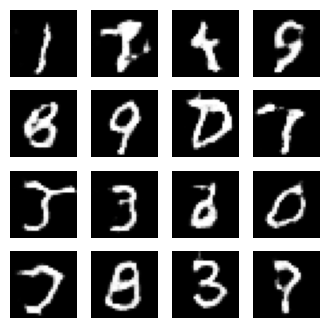

Time for epoch 75 is 6.822505474090576 sec
Time for epoch 76 is 6.329177141189575 sec
Time for epoch 77 is 6.299820423126221 sec
Time for epoch 78 is 6.316479921340942 sec
Time for epoch 79 is 6.330691814422607 sec
Time for epoch 80 is 6.35078763961792 sec
Time for epoch 81 is 6.306244373321533 sec
Time for epoch 82 is 6.315264701843262 sec
Time for epoch 83 is 6.325936555862427 sec
Time for epoch 84 is 6.323473930358887 sec
Time for epoch 85 is 6.334811210632324 sec
Time for epoch 86 is 6.31157374382019 sec
Time for epoch 87 is 6.3441383838653564 sec
Time for epoch 88 is 6.305834770202637 sec
Time for epoch 89 is 6.339949369430542 sec
Time for epoch 90 is 6.301967620849609 sec
Time for epoch 91 is 6.344331502914429 sec
Time for epoch 92 is 6.3048975467681885 sec
Time for epoch 93 is 6.3131020069122314 sec
Time for epoch 94 is 6.292370796203613 sec
Time for epoch 95 is 6.299975633621216 sec
Time for epoch 96 is 6.290224552154541 sec
Time for epoch 97 is 6.294141530990601 sec
Time for e

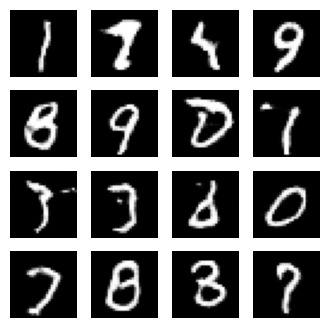

Time for epoch 150 is 6.824552297592163 sec


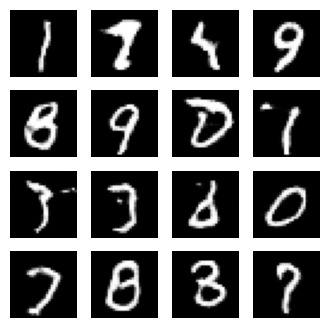

In [ ]:
generator_losses, discriminator_losses = train(train_dataset, num_epochs)


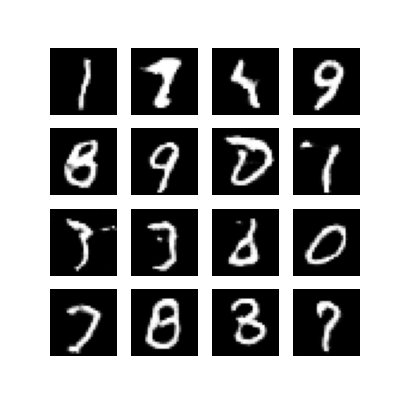

In [ ]:
display_image(150)


In [ ]:
generator.save_weights('dcgan_generator_0_1.h5')
discriminator.save_weights('dcgan_discriminator_0_1.h5')

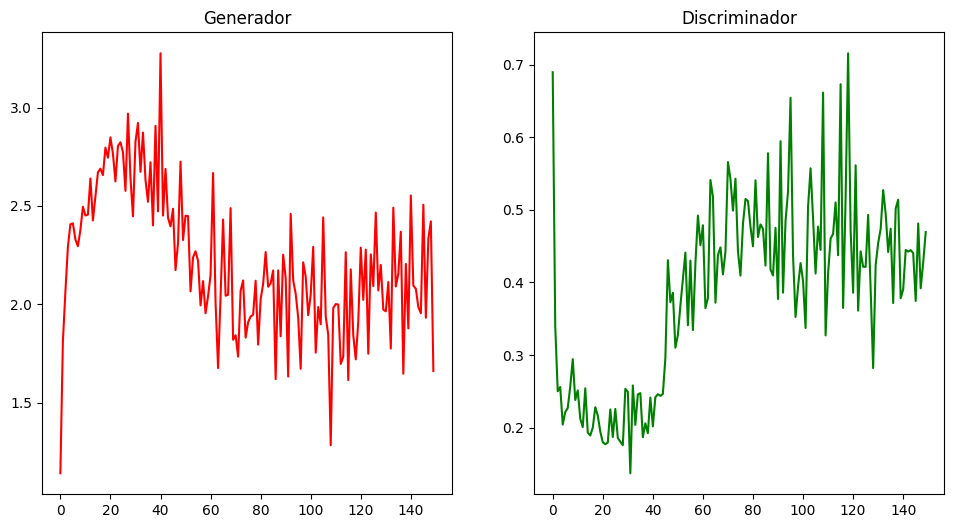

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(generator_losses, 'r')
plt.title('Generador')
plt.subplot(132)
plt.plot(discriminator_losses, 'g')
plt.title('Discriminador')
plt.show()